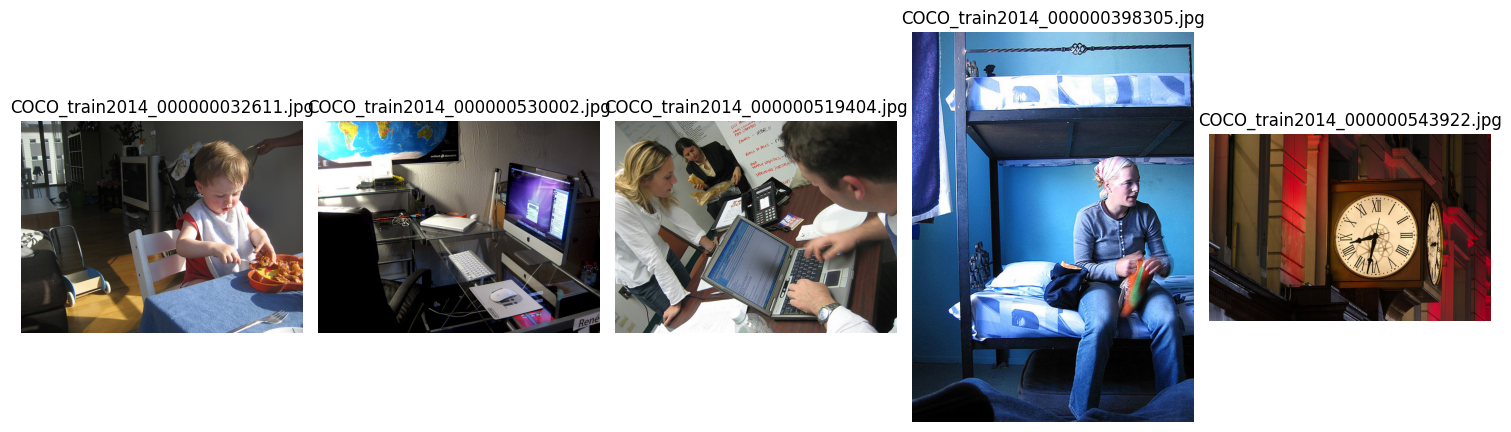

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory path
image_dir = '/kaggle/input/vqa-dataset/train2014'

# List the first 5 images
image_files = os.listdir(image_dir)[-5:]

# Display the images
fig, ax = plt.subplots(1, len(image_files), figsize=(15, 5))
for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)
    img = Image.open(image_path)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(image_file)
plt.tight_layout()
plt.show()


# **Data Preprocessing**

**Building vocab**

In [3]:
import json
from collections import Counter

# Paths to files
annotations_path = "/kaggle/input/json-files/v2_mscoco_train2014_annotations.json"
output_vocab_path = "/kaggle/working/answer_vocab.json"

# Parameters
k = 1000  # Number of top most frequent answers to include

# Step 1: Load the annotations file
with open(annotations_path, "r") as f:
    annotations_data = json.load(f)

# Step 2: Extract all answers
all_answers = [ans["answer"] for annotation in annotations_data["annotations"] for ans in annotation["answers"]]

# Step 3: Count answer frequencies and select the top K answers
answer_counts = Counter(all_answers)
most_common_answers = answer_counts.most_common(k)

# Step 4: Build the vocabulary with indices
answer_vocab = {answer: idx for idx, (answer, _) in enumerate(most_common_answers, start=1)}
answer_vocab["<unk>"] = 0  # Add an <unk> token for unseen answers

# Step 5: Save the vocabulary to a JSON file
with open(output_vocab_path, "w") as f:
    json.dump(answer_vocab, f, indent=4)

print(f"Answer vocabulary with {len(answer_vocab)} entries saved at: {output_vocab_path}")


Answer vocabulary with 1001 entries saved at: /kaggle/working/answer_vocab.json


**Checking the vocab**

In [4]:
# Path to the saved vocabulary file
vocab_path = "/kaggle/working/answer_vocab.json"

# Load and check the vocabulary file
with open(vocab_path, "r") as f:
    vocab = json.load(f)

# Print the total number of answers and first 10 entries
print(f"Total answers in the vocabulary: {len(vocab)}")
print("First 10 entries in the vocabulary:")
for idx, (answer, index) in enumerate(vocab.items()):
    print(f"{idx + 1}. {answer}: {index}")
    if idx == 9:  # Show only first 10 entries
        break


Total answers in the vocabulary: 1001
First 10 entries in the vocabulary:
1. no: 1
2. yes: 2
3. 2: 3
4. 1: 4
5. white: 5
6. 3: 6
7. red: 7
8. black: 8
9. blue: 9
10. 0: 10


**MAP ANSWERS TO INDICES**

In [5]:
import json

# Paths to files
annotations_path = "/kaggle/input/json-files/v2_mscoco_train2014_annotations.json"
vocab_path = "/kaggle/working/answer_vocab.json"
output_annotations_path = "/kaggle/working/mapped_annotations.json"

# Step 1: Load the annotations file and answer vocabulary
with open(annotations_path, "r") as f:
    annotations_data = json.load(f)

with open(vocab_path, "r") as f:
    answer_vocab = json.load(f)

# Step 2: Map answers to their vocabulary indices
for annotation in annotations_data["annotations"]:
    # Map the 'multiple_choice_answer' to its index
    answer = annotation["multiple_choice_answer"]
    annotation["mapped_answer"] = answer_vocab.get(answer, 0)  # Use <unk> index if answer not in vocab

    # Map all answers in the 'answers' list
    for ans in annotation["answers"]:
        mapped_index = answer_vocab.get(ans["answer"], 0)  # Use <unk> index if answer not in vocab
        ans["mapped_answer"] = mapped_index

# Step 3: Save the updated annotations file
with open(output_annotations_path, "w") as f:
    json.dump(annotations_data, f, indent=4)

print(f"Updated annotations file with mapped answers saved at: {output_annotations_path}")


Updated annotations file with mapped answers saved at: /kaggle/working/mapped_annotations.json


**CHECKING THE ANNOTATIONS FILE**

In [6]:
# Path to the updated annotations file
updated_annotations_path = "/kaggle/working/mapped_annotations.json"

# Load the updated annotations file
with open(updated_annotations_path, "r") as f:
    updated_annotations = json.load(f)

# Display the first 3 annotations to verify
print("Sample of updated annotations (first 3 entries):")
for annotation in updated_annotations["annotations"][:3]:
    print(f"Question ID: {annotation['question_id']}")
    print(f"Multiple Choice Answer (original): {annotation['multiple_choice_answer']}")
    print(f"Mapped Answer Index: {annotation['mapped_answer']}")
    print("Mapped Answers in 'answers' list:")
    for ans in annotation["answers"]:
        print(f"  - Original: {ans['answer']}, Mapped: {ans['mapped_answer']}")
    print("-" * 50)


Sample of updated annotations (first 3 entries):
Question ID: 458752000
Multiple Choice Answer (original): net
Mapped Answer Index: 904
Mapped Answers in 'answers' list:
  - Original: net, Mapped: 904
  - Original: net, Mapped: 904
  - Original: net, Mapped: 904
  - Original: netting, Mapped: 0
  - Original: net, Mapped: 904
  - Original: net, Mapped: 904
  - Original: mesh, Mapped: 0
  - Original: net, Mapped: 904
  - Original: net, Mapped: 904
  - Original: net, Mapped: 904
--------------------------------------------------
Question ID: 458752001
Multiple Choice Answer (original): pitcher
Mapped Answer Index: 395
Mapped Answers in 'answers' list:
  - Original: pitcher, Mapped: 395
  - Original: catcher, Mapped: 313
  - Original: pitcher, Mapped: 395
  - Original: pitcher, Mapped: 395
  - Original: pitcher, Mapped: 395
  - Original: pitcher, Mapped: 395
  - Original: pitcher, Mapped: 395
  - Original: pitcher, Mapped: 395
  - Original: pitcher, Mapped: 395
  - Original: pitcher, Mappe

**TOKENIZING THE QUESTIONS AND UPDATED THE ANNOTATIONS FILE**

In [7]:
import json
from transformers import BertTokenizer

# Paths to files
questions_path = "/kaggle/input/json-files/v2_OpenEnded_mscoco_train2014_questions.json"
updated_annotations_path = "/kaggle/working/mapped_annotations.json"
tokenized_questions_output_path = "/kaggle/working/tokenized_questions_with_ids.json"
final_annotations_output_path = "/kaggle/working/updated_annotations_with_tokens.json"

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Step 1: Load the questions and annotations files
with open(questions_path, "r") as f:
    questions_data = json.load(f)

with open(updated_annotations_path, "r") as f:
    annotations_data = json.load(f)

# Step 2: Tokenize questions and preserve their IDs
tokenized_questions = []
question_dict = {}

print("Tokenizing Questions...")
for question in questions_data["questions"]:
    question_id = question["question_id"]
    question_text = question["question"]

    # Tokenize and encode the question
    encoding = tokenizer(
        question_text,
        max_length=32,             # Max length of question tokens
        padding="max_length",      # Pad to max length
        truncation=True,           # Truncate if longer than max length
        return_tensors="pt",       # Return PyTorch tensors
        add_special_tokens=True    # Include [CLS] and [SEP]
    )

    # Convert tensors to lists
    input_ids = encoding["input_ids"].squeeze().tolist()
    attention_mask = encoding["attention_mask"].squeeze().tolist()

    # Add to tokenized questions list
    tokenized_questions.append({
        "question_id": question_id,
        "input_ids": input_ids,
        "attention_mask": attention_mask
    })

    # Map question_id to tokenized data for linking with annotations
    question_dict[question_id] = {"input_ids": input_ids, "attention_mask": attention_mask}

# Step 3: Update annotations with tokenized question data
print("Linking Tokenized Questions to Annotations...")
for annotation in annotations_data["annotations"]:
    question_id = annotation["question_id"]
    if question_id in question_dict:
        annotation["tokenized_question"] = question_dict[question_id]

# Step 4: Save the tokenized questions and updated annotations
with open(tokenized_questions_output_path, "w") as f:
    json.dump(tokenized_questions, f, indent=4)

with open(final_annotations_output_path, "w") as f:
    json.dump(annotations_data, f, indent=4)

print("Tokenized questions saved at:", tokenized_questions_output_path)
print("Updated annotations with tokens saved at:", final_annotations_output_path)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizing Questions...
Linking Tokenized Questions to Annotations...
Tokenized questions saved at: /kaggle/working/tokenized_questions_with_ids.json
Updated annotations with tokens saved at: /kaggle/working/updated_annotations_with_tokens.json


**CHECKING THE TOKENIZED QUESTIONS FILE**

In [8]:
# Load and check the tokenized questions
with open(tokenized_questions_output_path, "r") as f:
    tokenized_questions = json.load(f)

print("Sample of tokenized_questions_with_ids.json (first 3 entries):")
for item in tokenized_questions[:3]:
    print(f"Question ID: {item['question_id']}")
    print(f"Input IDs: {item['input_ids']}")
    print(f"Attention Mask: {item['attention_mask']}")
    print("-" * 50)


Sample of tokenized_questions_with_ids.json (first 3 entries):
Question ID: 458752000
Input IDs: [101, 2054, 2003, 2023, 6302, 2579, 2559, 2083, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
--------------------------------------------------
Question ID: 458752001
Input IDs: [101, 2054, 2597, 2003, 2023, 2158, 2652, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
--------------------------------------------------
Question ID: 458752002
Input IDs: [101, 2054, 3609, 2003, 1996, 2867, 3797, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
-------------------------

**CHECKING THE UPDATED ANNOTATION FILE**

In [9]:
import json

# Path to the updated annotations file
annotations_path = "updated_annotations_with_tokens.json"

# Load the updated annotations file
with open(annotations_path, 'r') as file:
    annotations_data = json.load(file)

# Print the first 3 entries to check the structure
print("Sample of updated_annotations_with_tokens.json (first 3 entries):")
for annotation in annotations_data['annotations'][3:5]:  # Adjust the number if needed
    print(f"\nQuestion ID: {annotation['question_id']}")
    print(f"Image ID: {annotation['image_id']}")
    print(f"Question Type: {annotation['question_type']}")
    print(f"Answer Type: {annotation['answer_type']}")
    print(f"Multiple Choice Answer: {annotation['multiple_choice_answer']}")
    print("Answers with Mapped Indices:")
    for ans in annotation['answers']:
        print(f"  - Original: {ans['answer']}, Mapped: {ans.get('mapped_answer', 'N/A')}")
    print("Tokenized Question:")
    print(f"  Input IDs: {annotation['tokenized_question']['input_ids']}")
    print(f"  Attention Mask: {annotation['tokenized_question']['attention_mask']}")


Sample of updated_annotations_with_tokens.json (first 3 entries):

Question ID: 458752003
Image ID: 458752
Question Type: is this
Answer Type: yes/no
Multiple Choice Answer: yes
Answers with Mapped Indices:
  - Original: yes, Mapped: 2
  - Original: yes, Mapped: 2
  - Original: yes, Mapped: 2
  - Original: yes, Mapped: 2
  - Original: yes, Mapped: 2
  - Original: no, Mapped: 1
  - Original: yes, Mapped: 2
  - Original: yes, Mapped: 2
  - Original: yes, Mapped: 2
  - Original: yes, Mapped: 2
Tokenized Question:
  Input IDs: [101, 2003, 2023, 2158, 1037, 2658, 3598, 2447, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Question ID: 262146000
Image ID: 262146
Question Type: what color is the
Answer Type: other
Multiple Choice Answer: white
Answers with Mapped Indices:
  - Original: white, Mapped: 5
  - Original: white, Mapped: 5
  - Original: whi

**STRUCTURE OF THE UPDATED ANNOTATIONS FILE**

In [10]:
import json

# Path to the updated annotations file
annotations_path = "updated_annotations_with_tokens.json"

# Load the JSON file
with open(annotations_path, 'r') as file:
    annotations_data = json.load(file)

# Function to print the structure recursively
def print_structure(data, indent=0):
    if isinstance(data, dict):
        for key, value in data.items():
            print("  " * indent + f"{key}: {type(value).__name__}")
            print_structure(value, indent + 1)
    elif isinstance(data, list):
        print("  " * indent + f"List[{len(data)} items]")
        if len(data) > 0:  # Print structure of the first item
            print_structure(data[0], indent + 1)

# Print the top-level structure
print("Structure of updated_annotations_with_tokens.json:\n")
print_structure(annotations_data)


Structure of updated_annotations_with_tokens.json:

info: dict
  description: str
  url: str
  version: str
  year: int
  contributor: str
  date_created: str
license: dict
  url: str
  name: str
data_subtype: str
annotations: list
  List[443757 items]
    question_type: str
    multiple_choice_answer: str
    answers: list
      List[10 items]
        answer: str
        answer_confidence: str
        answer_id: int
        mapped_answer: int
    image_id: int
    answer_type: str
    question_id: int
    mapped_answer: int
    tokenized_question: dict
      input_ids: list
        List[32 items]
      attention_mask: list
        List[32 items]
data_type: str


**DELETING THE MAPPED_ANNOTATIONS FILE**

In [11]:
import os

# Path to the file to delete
mapped_annotations_path = "/kaggle/working/mapped_annotations.json"

# Delete the file
if os.path.exists(mapped_annotations_path):
    os.remove(mapped_annotations_path)
    print(f"Deleted file: {mapped_annotations_path}")
else:
    print(f"File does not exist: {mapped_annotations_path}")


Deleted file: /kaggle/working/mapped_annotations.json


**Handle Multi-Label Answers (Majority Voting Approach)**

In [12]:
import json
from collections import Counter

# Paths
input_file = "/kaggle/working/updated_annotations_with_tokens.json"
output_file = "/kaggle/working/annotations_with_majority_answers.json"

# Load the annotations file
with open(input_file, 'r') as f:
    data = json.load(f)

# Process annotations to determine majority answer
for annotation in data['annotations']:
    # Extract mapped answers from the 'answers' list
    mapped_answers = [ans['mapped_answer'] for ans in annotation['answers']]

    # Count occurrences of each answer
    answer_counter = Counter(mapped_answers)

    # Choose the most common answer (majority vote)
    majority_answer = answer_counter.most_common(1)[0][0]

    # Add the majority answer to the annotation
    annotation['majority_answer'] = majority_answer

# Save the updated annotations to a new file
with open(output_file, 'w') as f:
    json.dump(data, f, indent=4)

print(f"Updated annotations with majority answers saved to: {output_file}")


Updated annotations with majority answers saved to: /kaggle/working/annotations_with_majority_answers.json


# **LOADING THE DATA**

In [13]:
import os
import json
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

# Define your data directory and annotation file paths
images_dir = '/kaggle/input/vqa-dataset/train2014'  # Replace with the actual path to your images
annotations_file =  '/kaggle/working/annotations_with_majority_answers.json'  # Use your processed annotation file

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 512x512 as per your preprocessing
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize
])

class VQADataset(Dataset):
    def __init__(self, images_dir, annotations_file, transform=None):
        self.images_dir = images_dir
        self.transform = transform

        # Load annotations (adjusting to your structure)
        with open(annotations_file, 'r') as f:
            data = json.load(f)
            self.annotations = data["annotations"]  

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Retrieve annotation for the given index
        annotation = self.annotations[idx]
    
        # Load image
        image_path = os.path.join(self.images_dir, f"COCO_train2014_{annotation['image_id']:012d}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")
    
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
    
        # Access tokenized question
        input_ids = torch.tensor(annotation['tokenized_question']['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(annotation['tokenized_question']['attention_mask'], dtype=torch.long)
    
        # Load answer (already mapped to an integer index)
        answer = torch.tensor(annotation['mapped_answer'], dtype=torch.long)
    
        return {
            "image": image,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "answer": answer
        }



# Load the dataset
dataset = VQADataset(images_dir, annotations_file, transform=transform)

# Split dataset into train, validation, and test sets
train_ratio = 0.2
val_ratio = 0.05
test_ratio = 0.05


# Calculate lengths for each split
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 16  # Set your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check data loader outputs 
for batch in train_loader:
    print(f"Image batch shape: {batch['image'].size()}")
    print(f"Input IDs batch shape: {batch['input_ids'].size()}")
    print(f"Attention mask batch shape: {batch['attention_mask'].size()}")
    print(f"Answer batch shape: {batch['answer'].size()}")
    break

print("Data loaders are ready.")


Image batch shape: torch.Size([16, 3, 224, 224])
Input IDs batch shape: torch.Size([16, 32])
Attention mask batch shape: torch.Size([16, 32])
Answer batch shape: torch.Size([16])
Data loaders are ready.


In [14]:
# Pick a batch from the training loader
for batch in train_loader:
    images = batch["image"]  # Extract image tensors
    print(f"Image batch shape: {images.size()}")  # Confirm tensor dimensions
    
    # Inspect the first image in the batch
    first_image = images[0]
    print(f"First image tensor shape: {first_image.size()}")
    
    # Check min and max values to confirm normalization
    print(f"First image tensor min value: {first_image.min()}")
    print(f"First image tensor max value: {first_image.max()}")
    
    # Convert the tensor back to an image to visualize (optional)
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))],
        std=[1 / s for s in (0.229, 0.224, 0.225)]
    )
    unnormalized_image = inv_normalize(first_image).clamp(0, 1)  # Undo normalization and clamp values to [0, 1]
    unnormalized_image = transforms.ToPILImage()(unnormalized_image)  # Convert to PIL image for visualization
    unnormalized_image.show()
    break  # Stop after inspecting one batch


Image batch shape: torch.Size([16, 3, 224, 224])
First image tensor shape: torch.Size([3, 224, 224])
First image tensor min value: -2.0494048595428467
First image tensor max value: 2.214658737182617


# **Building Resnet34 From Scratch**

**Residual Block**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

**ResNet34 Model Architecture**

In [16]:

class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 1001):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d(7, stride=1)
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x


**Training The ResNet34 Model**

In [17]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

num_classes = 1001
num_epochs = 5
batch_size = 16


model_resnet34 = ResNet(ResidualBlock, [3, 4, 6, 3])
# Wrap the model in DataParallel if multiple GPUs are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to the device (GPU or CPU)
model_resnet34.to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet34.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler

Using device: cuda


Training Loop

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Define number of epochs
num_epochs = 10  

# Initialize best validation accuracy for model saving
best_val_acc = 0.0

# Training loop
for epoch in range(num_epochs):
    model_resnet34.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Training phase
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = batch["image"].to(device)
        labels = batch["answer"].to(device)

        # Forward pass
        optimizer.zero_grad()  # Zero out gradients from previous iteration
        outputs = model_resnet34(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
    # Validation phase
    model_resnet34.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation needed during validation
        for batch in val_loader:
            images = batch["image"].to(device)
            labels = batch["answer"].to(device)

            outputs = model_resnet34(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    # Update the learning rate scheduler
    lr_scheduler.step()

    # Save the best model based on validation accuracy
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model_resnet34.state_dict(), 'best_resnet34.pth')

print("Training complete!")


Epoch 1/10: 100%|██████████| 5547/5547 [27:50<00:00,  3.32it/s]


Epoch 1/10, Loss: 4.0510
Validation Loss: 3.9688, Accuracy: 18.73%


Epoch 2/10: 100%|██████████| 5547/5547 [21:30<00:00,  4.30it/s]


Epoch 2/10, Loss: 3.9574
Validation Loss: 3.9229, Accuracy: 19.06%


Epoch 3/10: 100%|██████████| 5547/5547 [21:09<00:00,  4.37it/s]


Epoch 3/10, Loss: 3.9167
Validation Loss: 3.8687, Accuracy: 19.51%


Epoch 4/10: 100%|██████████| 5547/5547 [20:54<00:00,  4.42it/s]


Epoch 4/10, Loss: 3.8815
Validation Loss: 3.8482, Accuracy: 19.86%


Epoch 5/10: 100%|██████████| 5547/5547 [20:45<00:00,  4.45it/s]


Epoch 5/10, Loss: 3.8530
Validation Loss: 3.8314, Accuracy: 19.30%


Epoch 6/10: 100%|██████████| 5547/5547 [20:48<00:00,  4.44it/s]


Epoch 6/10, Loss: 3.8052
Validation Loss: 3.7965, Accuracy: 20.38%


Epoch 7/10: 100%|██████████| 5547/5547 [20:27<00:00,  4.52it/s]


Epoch 7/10, Loss: 3.7914
Validation Loss: 3.7878, Accuracy: 20.32%


Epoch 8/10: 100%|██████████| 5547/5547 [20:40<00:00,  4.47it/s]


Epoch 8/10, Loss: 3.7831
Validation Loss: 3.7825, Accuracy: 20.41%


Epoch 9/10:  32%|███▏      | 1772/5547 [06:39<14:03,  4.48it/s]

The training crashed because of our machines computational ressources.
(We ran out of RAM and our GPUs had no free memory left)

# **BUILDING RESNET50 FROM SCRATCH** 

Define the ResNet-50 Architecture

In [18]:
import torch
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResNet50(nn.Module):
    def __init__(self, num_classes=1001):  # Adjust `num_classes` for VQA
        super(ResNet50, self).__init__()
        self.in_channels = 64
        
        # Initial Conv Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet Blocks
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        
        # Final Layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


**Testing ResNet-50**

In [19]:
# Test the ResNet50 implementation
if __name__ == "__main__":
    model = ResNet50()  # For classification, adjust for VQA
    dummy_input = torch.randn(1, 3, 224, 224)  # Batch size of 1, RGB image of 224x224
    output = model(dummy_input)
    print("Output shape:", output.shape)


Output shape: torch.Size([1, 1001])


Sizes Check-up

In [20]:
# Pick a batch from the training loader
for batch in train_loader:
    images = batch["image"]  # Extract image tensors
    print(f"Image batch shape: {images.size()}")  # Confirm tensor dimensions
    
    # Inspect the first image in the batch
    first_image = images[0]
    print(f"First image tensor shape: {first_image.size()}")
    
    # Check min and max values to confirm normalization
    print(f"First image tensor min value: {first_image.min()}")
    print(f"First image tensor max value: {first_image.max()}")
    
    # Convert the tensor back to an image to visualize (optional)
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))],
        std=[1 / s for s in (0.229, 0.224, 0.225)]
    )
    unnormalized_image = inv_normalize(first_image).clamp(0, 1)  # Undo normalization and clamp values to [0, 1]
    unnormalized_image = transforms.ToPILImage()(unnormalized_image)  # Convert to PIL image for visualization
    unnormalized_image.show()
    break  # Stop after inspecting one batch


Image batch shape: torch.Size([16, 3, 224, 224])
First image tensor shape: torch.Size([3, 224, 224])
First image tensor min value: -1.9656862020492554
First image tensor max value: 2.6225709915161133


**Train ResNet50**

In [22]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

num_classes = 1001
num_epochs = 5
batch_size = 16


model_resnet50 = ResNet50()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to the device (GPU or CPU)
model_resnet34.to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet34.parameters(), lr=0.001)  
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

Using device: cuda


Training Loop

In [25]:
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.optim as optim
from tqdm import tqdm

# Define number of epochs
num_epochs = 5  

# Initialize best validation accuracy for model saving
best_val_acc = 0.0

# Training loop
for epoch in range(num_epochs):
    model_resnet50.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Training phase
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = batch["image"].to(device)
        labels = batch["answer"].to(device)

        # Forward pass
        optimizer.zero_grad()  # Zero out gradients from previous iteration
        outputs = model_resnet34(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
    # Validation phase
    model_resnet50.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation needed during validation
        for batch in val_loader:
            images = batch["image"].to(device)
            labels = batch["answer"].to(device)

            outputs = model_resnet34(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
     

    # Update the learning rate scheduler
    lr_scheduler.step()
    
    # Save best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model_resnet50.state_dict(), 'best_resnet50.pth')
            
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

print("Training complete!")

Epoch 1/5: 100%|██████████| 5547/5547 [21:23<00:00,  4.32it/s]


Epoch 1/5, Loss: 3.9422
Validation Loss: 3.9575, Accuracy: 19.08%
Validation Loss: 3.9575, Accuracy: 19.08%


Epoch 2/5: 100%|██████████| 5547/5547 [21:01<00:00,  4.40it/s]


Epoch 2/5, Loss: 3.9197
Validation Loss: 3.9535, Accuracy: 19.25%
Validation Loss: 3.9535, Accuracy: 19.25%


Epoch 3/5: 100%|██████████| 5547/5547 [21:01<00:00,  4.40it/s]


Epoch 3/5, Loss: 3.9163
Validation Loss: 3.9532, Accuracy: 19.33%
Validation Loss: 3.9532, Accuracy: 19.33%


Epoch 4/5: 100%|██████████| 5547/5547 [21:03<00:00,  4.39it/s]


Epoch 4/5, Loss: 3.9162
Validation Loss: 3.9531, Accuracy: 19.34%
Validation Loss: 3.9531, Accuracy: 19.34%


Epoch 5/5: 100%|██████████| 5547/5547 [21:28<00:00,  4.31it/s]


Epoch 5/5, Loss: 3.9153
Validation Loss: 3.9531, Accuracy: 19.34%
Validation Loss: 3.9531, Accuracy: 19.34%
Training complete!


**Bottleneck Version for Deeper Networks**

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class BottleneckBlock(nn.Module):
    expansion = 4  # Class variable for expansion factor
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        
        # First 1x1 conv layer reduces channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Second 1x1 conv layer expands channels
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, 
                              kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        # First bottleneck block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second block
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # Third block
        out = self.conv3(out)
        out = self.bn3(out)

        # Apply downsample if needed
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add residual connection
        out += identity
        out = self.relu(out)

        return out

**Model Architecture**

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1001):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, 
                              padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        # Create downsample layer if needed
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        # First block might need downsampling
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        
        # Update input channels for subsequent blocks
        self.in_channels = out_channels * block.expansion
        
        # Add remaining blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



**Train The Model**

Training Function

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_resnet(model, train_loader, val_loader, train_sampler=None, num_epochs=5, device='cuda'):
    """
    Train ResNet model with multi-GPU support.
    """
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        if train_sampler:
            train_sampler.set_epoch(epoch)  # Shuffle data for DistributedSampler
        
        # Training phase
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = batch["image"].to(device, non_blocking=True)
            labels = batch["answer"].to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device, non_blocking=True)
                labels = batch["answer"].to(device, non_blocking=True)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        # Update learning rate
        lr_scheduler.step()

        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_resnet50.pth')

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
        print("----------------------------------------")


In [33]:
import torch
import torch.nn as nn
import torch.distributed as dist



def create_resnet50(num_classes):
    """
    Create a ResNet50 model with support for both single and multi-GPU setups.
    """
    cnn_model = ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes=num_classes)
    
    device  = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    cnn_model = cnn_model.to(device)
    
    
    return cnn_model, device


**Test the Model's Architecture**

In [34]:
import torch
import torch.nn as nn
import numpy as np

def test_resnet50():
    """
    Comprehensive test suite for ResNet50 implementation
    """
    # Test configurations
    batch_sizes = [1, 4, 16]
    input_sizes = [224, 512]
    num_classes = 1001

    print("Starting ResNet50 tests...")
    print("-" * 50)

    try:
        # Create model
        model = ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes=num_classes)
        print("✓ Model instantiation successful")

        # Move to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print(f"✓ Model moved to {device}")

        # Test model architecture
        total_params = sum(p.numel() for p in model.parameters())
        print(f"✓ Total parameters: {total_params:,}")

        # Verify layer dimensions
        print("\nTesting different input configurations:")
        print("-" * 50)
        
        for batch_size in batch_sizes:
            for input_size in input_sizes:
                dummy_input = torch.randn(batch_size, 3, input_size, input_size).to(device)
                
                try:
                    with torch.no_grad():
                        output = model(dummy_input)
                    
                    expected_shape = (batch_size, num_classes)
                    assert output.shape == expected_shape, \
                        f"Expected shape {expected_shape}, got {output.shape}"
                    
                    print(f"✓ Passed: Batch size {batch_size}, Input size {input_size}x{input_size}")
                    print(f"  Input shape: {dummy_input.shape}")
                    print(f"  Output shape: {output.shape}")
                    
                except Exception as e:
                    print(f"✗ Failed: Batch size {batch_size}, Input size {input_size}x{input_size}")
                    print(f"  Error: {str(e)}")

        # Test forward/backward pass
        print("\nTesting forward/backward pass:")
        print("-" * 50)
        
        try:
            model.train()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()
            
            # Generate dummy batch
            dummy_batch = torch.randn(4, 3, 224, 224).to(device)
            dummy_labels = torch.randint(0, num_classes, (4,)).to(device)
            
            # Forward pass
            outputs = model(dummy_batch)
            loss = criterion(outputs, dummy_labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print("✓ Forward/backward pass successful")
            print(f"  Test loss: {loss.item():.4f}")
            
        except Exception as e:
            print("✗ Forward/backward pass failed")
            print(f"  Error: {str(e)}")

        # Test model components
        print("\nTesting model components:")
        print("-" * 50)
        
        # Test Bottleneck Block with proper dimensions
        try:
            in_channels = 64
            out_channels = 64
            # Create block with downsample to handle expansion factor
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleneckBlock.expansion,
                         kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleneckBlock.expansion)
            )
            test_block = BottleneckBlock(in_channels, out_channels, 
                                       stride=1, downsample=downsample).to(device)
            
            test_input = torch.randn(1, in_channels, 56, 56).to(device)
            test_output = test_block(test_input)
            print("✓ Bottleneck Block test passed")
            print(f"  Input shape: {test_input.shape}")
            print(f"  Output shape: {test_output.shape}")
            
            # Additional shape verification
            expected_output_channels = out_channels * BottleneckBlock.expansion
            assert test_output.shape == (1, expected_output_channels, 56, 56), \
                f"Expected shape (1, {expected_output_channels}, 56, 56), got {test_output.shape}"
            print(f"  ✓ Output channels verified: {expected_output_channels}")
            
        except Exception as e:
            print("✗ Bottleneck Block test failed")
            print(f"  Error: {str(e)}")

        print("\nAll tests completed!")

    except Exception as e:
        print(f"\n✗ Test suite failed with error: {str(e)}")

if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Run tests
    test_resnet50()

    # Additional memory cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Starting ResNet50 tests...
--------------------------------------------------
✓ Model instantiation successful
✓ Model moved to cuda
✓ Total parameters: 25,559,081

Testing different input configurations:
--------------------------------------------------
✓ Passed: Batch size 1, Input size 224x224
  Input shape: torch.Size([1, 3, 224, 224])
  Output shape: torch.Size([1, 1001])
✓ Passed: Batch size 1, Input size 512x512
  Input shape: torch.Size([1, 3, 512, 512])
  Output shape: torch.Size([1, 1001])
✓ Passed: Batch size 4, Input size 224x224
  Input shape: torch.Size([4, 3, 224, 224])
  Output shape: torch.Size([4, 1001])
✓ Passed: Batch size 4, Input size 512x512
  Input shape: torch.Size([4, 3, 512, 512])
  Output shape: torch.Size([4, 1001])
✓ Passed: Batch size 16, Input size 224x224
  Input shape: torch.Size([16, 3, 224, 224])
  Output shape: torch.Size([16, 1001])
✓ Passed: Batch size 16, Input size 512x512
  Input shape: torch.Size([16, 3, 512, 512])
  Output shape: torch.Size(

**Training The Model**

In [35]:
# Initialize 
num_classes = 1001  # Your number of classes
cnn_model, device = create_resnet50(num_classes)
print(f"Model is on device: {next(cnn_model.parameters()).device}")

Model is on device: cuda:0


In [36]:
# Train
train_resnet(cnn_model, train_loader, val_loader, num_epochs=5, device=device)

Epoch 1/5: 100%|██████████| 5547/5547 [28:03<00:00,  3.29it/s]


Epoch 1/5
Training Loss: 4.0785
Validation Loss: 4.0163, Accuracy: 18.44%
Best Validation Accuracy: 18.44%
----------------------------------------


Epoch 2/5: 100%|██████████| 5547/5547 [27:23<00:00,  3.37it/s]


Epoch 2/5
Training Loss: 3.9658
Validation Loss: 3.9763, Accuracy: 19.27%
Best Validation Accuracy: 19.27%
----------------------------------------


Epoch 3/5: 100%|██████████| 5547/5547 [27:15<00:00,  3.39it/s]


Epoch 3/5
Training Loss: 3.9405
Validation Loss: 3.9712, Accuracy: 19.48%
Best Validation Accuracy: 19.48%
----------------------------------------


Epoch 4/5: 100%|██████████| 5547/5547 [27:24<00:00,  3.37it/s]


Epoch 4/5
Training Loss: 3.9359
Validation Loss: 3.9703, Accuracy: 19.40%
Best Validation Accuracy: 19.48%
----------------------------------------


Epoch 5/5: 100%|██████████| 5547/5547 [27:19<00:00,  3.38it/s]


Epoch 5/5
Training Loss: 3.9363
Validation Loss: 3.9708, Accuracy: 19.44%
Best Validation Accuracy: 19.48%
----------------------------------------


Save the optimizer

In [37]:
## Save the optimizer state
torch.save(optimizer.state_dict(), "optimizer_resnet50.pth")
print("Optimizer state saved.")

Optimizer state saved.
